In [1]:
import pandas as pd
import dtale
import plotly.express as px 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

# Imported Clean CSV

In [2]:
df = pd.read_csv("../data/outcomes.csv")

unique_ids = df['CallerNum'].nunique()
df.head()

,Unnamed: 0,CallerNum,Treatment Plan - Is the treatment plan completed?,"Treatment Plan - Was the enrollee able to be restored to function (can chew) and ""social six"" esthetics (top front six teeth are present and disease free)",Birth_Year,Presumptive Eligibility - Do they pre-qualify for SMILE ON 60+?,Base-line Oral and Conditions Questions - Are you limited in what you can eat?,Treatment Plan - Was a treatment plan developed?
0,0,3638169,NaN,NaN,1960,Yes,Yes,NaN
1,1,4431194,NaN,NaN,1959,Yes,Yes,NaN
2,2,2941341,No,No,1942,Yes,No,Yes
3,3,3823933,No,No,1960,Yes,Yes,Yes
4,4,3348256,No,No,1955,Yes,Yes,Yes


# Value Counts for two main metrics: Completed Plan and Restorated Function (with duplicate patient ids)

In [3]:
print(df['Treatment Plan - Is the treatment plan completed?'].value_counts())
print(df['Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)'].value_counts())

No     19382
Yes     7823
Name: Treatment Plan - Is the treatment plan completed?, dtype: int64
No     12260
Yes     9794
Name: Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free), dtype: int64


### Drop columns that are not used

In [4]:
df.drop(columns=['Presumptive Eligibility - Do they pre-qualify for SMILE ON 60+?','Birth_Year'], inplace=True)
del df['Unnamed: 0']

# Rename Columns for counting purposes

In [5]:
new_names = {'CallerNum':'Patient_id',
             'Treatment Plan - Is the treatment plan completed?':'Plan_Completed',
             'Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)':'Restored_Function',
             'Treatment Plan - Was a treatment plan developed?':'Plan_developed',
             'Base-line Oral and Conditions Questions - Are you limited in what you can eat?':'Limited'}

In [6]:
df.rename(columns=new_names, inplace=True)
df.head()

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
0,3638169,NaN,NaN,Yes,NaN
1,4431194,NaN,NaN,Yes,NaN
2,2941341,No,No,No,Yes
3,3823933,No,No,Yes,Yes
4,3348256,No,No,Yes,Yes


# Sorted and dropped duplicates of Patient ids

In [7]:
sorted = df.sort_values(['Patient_id',
                         'Plan_Completed',
                         'Restored_Function',
                         'Plan_developed',
                         'Limited']).drop_duplicates(['Patient_id'], keep='first')
sorted.head()

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
47543,-2,NaN,NaN,No,Yes
609,-1,No,No,NaN,Yes
34169,2384106,No,No,Yes,Yes
3701,2384744,No,No,No,Yes
54215,2384833,Yes,Yes,No,Yes


In [8]:
print(sorted['Plan_Completed'].value_counts())
print(sorted['Restored_Function'].value_counts())
print(sorted['Plan_developed'].value_counts())
print(sorted['Limited'].value_counts())

No     5522
Yes     883
Name: Plan_Completed, dtype: int64
No     4179
Yes    1411
Name: Restored_Function, dtype: int64
Yes    5745
No      698
Name: Plan_developed, dtype: int64
Yes    5089
No     3946
Name: Limited, dtype: int64


In [9]:
l_no_na = sorted[sorted['Limited'].notna()]
pd_no_na = sorted[sorted['Plan_developed'].notna()]
pc_no_na = sorted[sorted['Plan_Completed'].notna()]
rf_no_na = sorted[sorted['Restored_Function'].notna()]


# Sorted by Sub-metric: Limited(chew capability), Plan Developed, Plan Completed, and Restored Function.

## Level 1
#### Documented that all submetrics were answered as 'Yes'

In [10]:
completed_1 = sorted[(sorted['Limited'] == 'Yes') & 
                (sorted['Plan_developed'] == 'Yes') & 
                (sorted['Plan_Completed'] == 'Yes') & 
                (sorted['Restored_Function'] == 'Yes') ]
completed_1.head(5)

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
52758,2386054,Yes,Yes,Yes,Yes
48392,2386075,Yes,Yes,Yes,Yes
54439,2387558,Yes,Yes,Yes,Yes
42557,2391110,Yes,Yes,Yes,Yes
53674,2392454,Yes,Yes,Yes,Yes


### Percentages  
##### .mul(100).round(1).astype(str) + '%'

In [11]:
level_1= (completed_1['Restored_Function'].value_counts()/unique_ids).mul(100).round(1).astype(str) + '%'
level_1

Yes    2.2%
Name: Restored_Function, dtype: object

## Level 2
#### Documented that Plan was developed, Plan was completed and Returned to Function were answered as 'Yes'

In [12]:
completed_2 = sorted[ (sorted['Plan_developed'] == 'Yes') & 
                      (sorted['Plan_Completed'] == 'Yes') & 
                      (sorted['Restored_Function'] == 'Yes') ]
completed_2.head(5)

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
54215,2384833,Yes,Yes,No,Yes
27851,2384932,Yes,Yes,NaN,Yes
53228,2384971,Yes,Yes,No,Yes
56333,2385168,Yes,Yes,No,Yes
48129,2385321,Yes,Yes,NaN,Yes


In [13]:
level_2= (completed_2['Restored_Function'].value_counts()/unique_ids).mul(100).round(1).astype(str) + '%'
level_2

Yes    6.2%
Name: Restored_Function, dtype: object

## Level 3
#### Documented that a Plan was completed and Returned to Function were answered as 'Yes'

In [14]:
completed_3 = sorted[ (sorted['Plan_Completed'] == 'Yes') & 
                      (sorted['Restored_Function'] == 'Yes') ]
completed_3.head(5)

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
54215,2384833,Yes,Yes,No,Yes
27851,2384932,Yes,Yes,NaN,Yes
53228,2384971,Yes,Yes,No,Yes
56333,2385168,Yes,Yes,No,Yes
48129,2385321,Yes,Yes,NaN,Yes


In [15]:
level_3= (completed_3['Restored_Function'].value_counts()/unique_ids).mul(100).round(1).astype(str) + '%'
level_3

Yes    6.9%
Name: Restored_Function, dtype: object

## Level 4
#### Documented that Returned to Function were answered as 'Yes'

In [16]:
completed_4 = sorted[#(sorted['Plan_Completed'] == 'No') |
                      (sorted['Restored_Function'] == 'Yes') ]
completed_4.head(5)

,Patient_id,Plan_Completed,Restored_Function,Limited,Plan_developed
54215,2384833,Yes,Yes,No,Yes
27851,2384932,Yes,Yes,NaN,Yes
55200,2384963,No,Yes,NaN,Yes
53228,2384971,Yes,Yes,No,Yes
53360,2385046,NaN,Yes,No,Yes


In [17]:
level_4= (completed_4['Restored_Function'].value_counts()/unique_ids).mul(100).round(1).astype(str) + '%'
level_4

Yes    13.2%
Name: Restored_Function, dtype: object

# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

duplicates = sorted.duplicated(['Patient_id'], keep='first')
sorted= sorted[~duplicates]
if isinstance(sorted, (pd.DatetimeIndex, pd.MultiIndex)):
    sorted = sorted.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
sorted = sorted.reset_index().drop('index', axis=1, errors='ignore')
sorted.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

sorted.head()

print(sorted['Plan_Completed'].value_counts())
print(sorted['Restored_Function'].value_counts())

In [18]:
print(completed_4['Restored_Function'].value_counts())
print(level_4)
print(completed_3['Restored_Function'].value_counts())
print(level_3)
print(completed_2['Restored_Function'].value_counts())
print(level_2)
print(completed_1['Restored_Function'].value_counts())
print(level_1)
print(unique_ids)

Yes    1411
Name: Restored_Function, dtype: int64
Yes    13.2%
Name: Restored_Function, dtype: object
Yes    743
Name: Restored_Function, dtype: int64
Yes    6.9%
Name: Restored_Function, dtype: object
Yes    662
Name: Restored_Function, dtype: int64
Yes    6.2%
Name: Restored_Function, dtype: object
Yes    238
Name: Restored_Function, dtype: int64
Yes    2.2%
Name: Restored_Function, dtype: object
10711


Text(0, 0.5, 'Patient_Count')

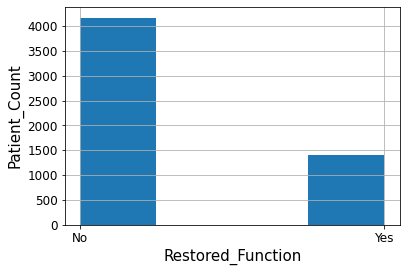

In [19]:
sorted['Restored_Function'].hist(bins=4, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Restored_Function", fontsize=15)
plt.ylabel("Patient_Count",fontsize=15)

In [205]:
Smile_df = pd.DataFrame({'Patient Count': [1411, 743, 662, 238],
                   'Patient Percentage': [13.2, 6.9, 6.2, 2.2],
                        'Documented Cases':['Function Restored', 'Plan Completed',
                                             'Full Plan','Full Service']},
                  index=['Level 4','Level 3', 'Level 2', 'Level 1'])
Smile_df

,Patient Count,Patient Percentage,Documented Cases
Level 4,1411,13.2,Function Restored
Level 3,743,6.9,Plan Completed
Level 2,662,6.2,Full Plan
Level 1,238,2.2,Full Service


In [21]:
frames = [sorted, Smile_df]

In [22]:
smile_plus = pd.concat(frames)

In [ ]:
# Pie chart
fig = px.pie(smile_plus, values='Patient_Percentage', names='Patient_Count')
fig.show()

In [ ]:
# Bubble chart
fig = px.scatter(Smile_df.assign(dataType='Patient_Count'), 
                 color='Levels of Success', x='Patient_Count', 
                 y='dataType', size='Patient_Percentage', 
                 size_max=50)
fig.show()

In [ ]:
# Horizontal bar chart - stacked
fig = px.bar(Smile_df, color='Patient_Percentage', x='Levels of Success', orientation='h')
fig.show()

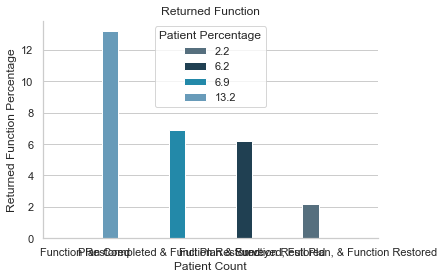

In [96]:
# Create an array with the colors you want to use
colors = ["#507184","#18425A","#0D94BF","#5b9fc6"]



# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
# And then, from here onwards, it's exactly like the previous example
# Plot the data, specifying a different color for data points in
# each of the day categories (weekday and weekend)
ax = sns.barplot(x='Documented Cases', y='Patient Percentage', data=Smile_df, hue='Patient Percentage')
# Customize the axes and title
ax.set_title("Returned Function")
ax.set_xlabel("Patient Count")
ax.set_ylabel("Returned Function Percentage")
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [133]:
# Bar chart
fig = px.bar(Smile_df, color='Patient Count', x='Documented Cases', y='Patient Percentage')
fig.update_layout(paper_bgcolor="#FBF9F9")
fig.update_layout(xaxis = dict(tickfont=dict(size=12)))
fig.update_layout(yaxis = dict(tickfont=dict(size=14)))
fig.update_layout(xaxis = dict(tickfont=dict(size=12)))
fig.show()

In [208]:
import plotly.express as px
#data = px.data.gapminder()

# Create an array with the colors you want to use
colors = ["#507184","#18425A","#0D94BF","#5b9fc6"]


# Set your custom color palette

#data_canada = data[data.country == 'Canada']
fig = px.bar(Smile_df, x='Documented Cases', y='Patient Percentage', title="Was Smile On successful?",
             hover_data=['Patient Count', 'Patient Percentage'], color='Patient Count',
              color_continuous_scale=px.colors.sequential.Blues,
            labels={'Success':'Documented Cases'}, height=800)

for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
    fig.update_layout(template=template)

fig.update_layout(paper_bgcolor="#FBF9F9")
fig.update_layout(
    legend_title="Legend Title",
    font=dict(
        family="Lora, monospace",
        size=18,
        color="#18425A"))

fig.update_layout(xaxis = dict(tickfont=dict(size=18)))
fig.update_layout(yaxis = dict(tickfont=dict(size=26)))
fig.update_traces( marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)

fig.show()


plt.savefig('../data/dental_condition.png')


<Figure size 432x288 with 0 Axes>

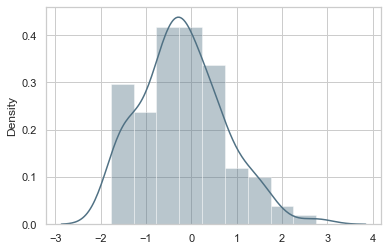

In [44]:
# Wanted palette details
smileplus_palette = ["#980000", "#FBF9F9", "#18425A","#507184","#0D94BF"]
color_codes_wanted = ['red', 'white', 'dark blue','light blue', 'bright blue']

c = lambda x: smileplus_palette[color_codes_wanted.index(x)]

x=np.random.randn(100)
g = sns.distplot(x, color=c("light blue"))

plt.show()

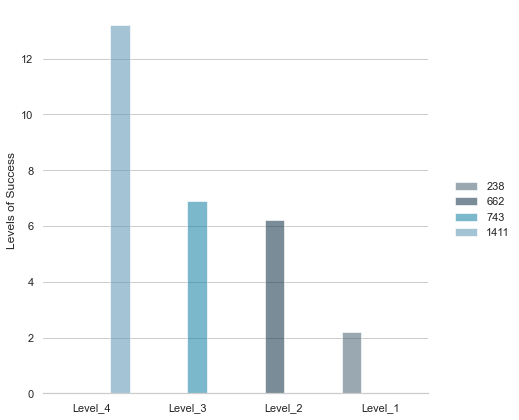

In [50]:
import seaborn as sns
sns.set_theme(style="whitegrid")

#penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=Smile_df, kind="bar",
    x="Levels of Success", y="Patient_Percentage", hue="Patient_Count",
    ci="sd", palette=colors, alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Levels of Success")
g.legend.set_title("")


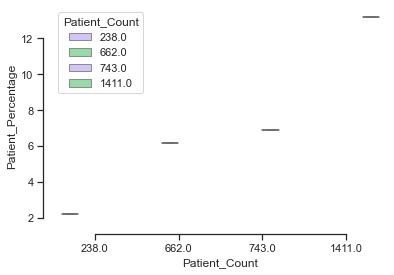

In [30]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")


# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Patient_Count", y="Patient_Percentage",
            hue="Patient_Count", palette=["m", "g"],
            data=smile_plus)
sns.despine(offset=10, trim=True)

In [ ]:
print(sorted['Patient_id'].value_counts())

In [ ]:
#dental_df[dental_df['Are you limited to what you eat?'] == 'Yes']['Age'].describe
#dental_df[dental_df['Are you limited to what you eat?'] == 'Yes']['Age'].value_counts(normalize = True)


In [ ]:
d = dtale.show(Smile_df)

#open it in a new window in browser

d.open_browser()